In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [21]:
import pandas as pd
import numpy as np
import re
import string
import time
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor

# Sklearn metrics and utilities
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, mean_squared_error, r2_score

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [22]:
# Download stopwords if not already present
try:
    stopwords.words('english')
except LookupError:
    import nltk
    nltk.download('stopwords')
    nltk.download('punkt') # Also download punkt here for efficiency

In [29]:

df = pd.read_csv("Musical_instruments_reviews.csv")

# Drop rows with missing reviewText or overall score
df.dropna(subset=['reviewText', 'overall'], inplace=True)


stop_words = set(stopwords.words('english'))
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags (simple way)
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize and remove stop words
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

print("Cleaning reviewText...")
start_time = time.time()
df['cleaned_review'] = df['reviewText'].apply(clean_text)
print(f"Cleaning complete in {time.time()-start_time:.2f}s")

Cleaning reviewText...
Cleaning complete in 2.45s


In [24]:
# --- TF-IDF Vectorization ---
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['cleaned_review'])
print("TF-IDF shape:", X_tfidf.shape)

# --- Targets ---
df['overall_int'] = df['overall'].astype(int)
y_clf = df['overall_int'] - 1
y_reg = df['overall']

# --- Train/Test Split ---
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_tfidf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_tfidf, y_reg, test_size=0.2, random_state=42
)
print("Data split done!")

TF-IDF shape: (10254, 5000)
Data split done!


In [25]:
# --- Classification Models ---
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=200, n_jobs=-1),
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=50, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=50, max_depth=5, random_state=42, n_jobs=-1)
}

results_clf = []
best_acc = 0

print("\n--- CLASSIFICATION ---")
for name, model in classifiers.items():
    start = time.time()
    model.fit(X_train_clf, y_train_clf)
    y_pred = model.predict(X_test_clf)
    acc = accuracy_score(y_test_clf, y_pred)
    prec = precision_score(y_test_clf, y_pred, average='macro')
    rec = recall_score(y_test_clf, y_pred, average='macro')
    f1 = f1_score(y_test_clf, y_pred, average='macro')
    results_clf.append([name, acc, prec, rec, f1])
    print(f"{name}: Acc={acc:.3f}, F1={f1:.3f}, Time={time.time()-start:.2f}s")
    if acc > best_acc:
        best_acc = acc
        best_clf_model = model
        best_clf_name = name

results_df_clf = pd.DataFrame(results_clf, columns=["Model", "Accuracy", "Precision", "Recall", "F1"])
print("\nCLASSIFICATION RESULTS:\n", results_df_clf)




--- CLASSIFICATION ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression: Acc=0.689, F1=0.223, Time=1.87s
Naive Bayes: Acc=0.678, F1=0.165, Time=0.01s
KNN: Acc=0.629, F1=0.230, Time=1.33s
Decision Tree: Acc=0.592, F1=0.265, Time=3.78s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest: Acc=0.679, F1=0.174, Time=3.43s
Gradient Boosting: Acc=0.679, F1=0.206, Time=26.07s
XGBoost: Acc=0.689, F1=0.224, Time=17.98s

CLASSIFICATION RESULTS:
                  Model  Accuracy  Precision    Recall        F1
0  Logistic Regression  0.689420   0.317832  0.231952  0.223035
1          Naive Bayes  0.677718   0.249902  0.201774  0.165359
2                  KNN  0.628961   0.297678  0.228205  0.230363
3        Decision Tree  0.591906   0.275637  0.259049  0.264838
4        Random Forest  0.679181   0.423316  0.205374  0.173593
5    Gradient Boosting  0.679181   0.382822  0.224519  0.205756
6              XGBoost  0.688932   0.361809  0.231728  0.224028


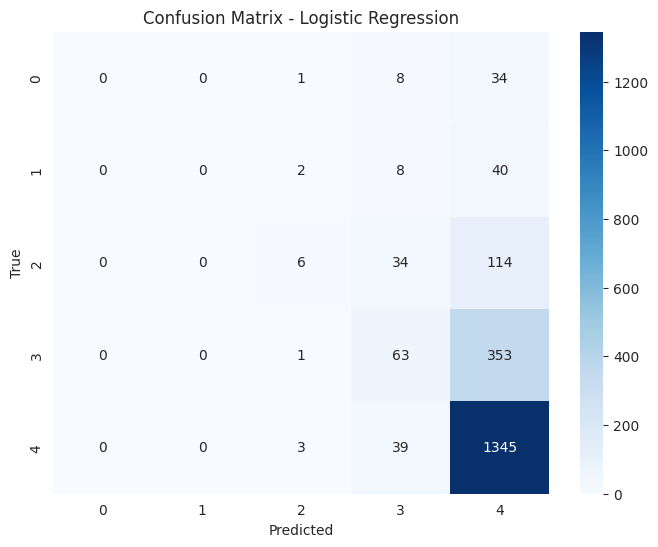

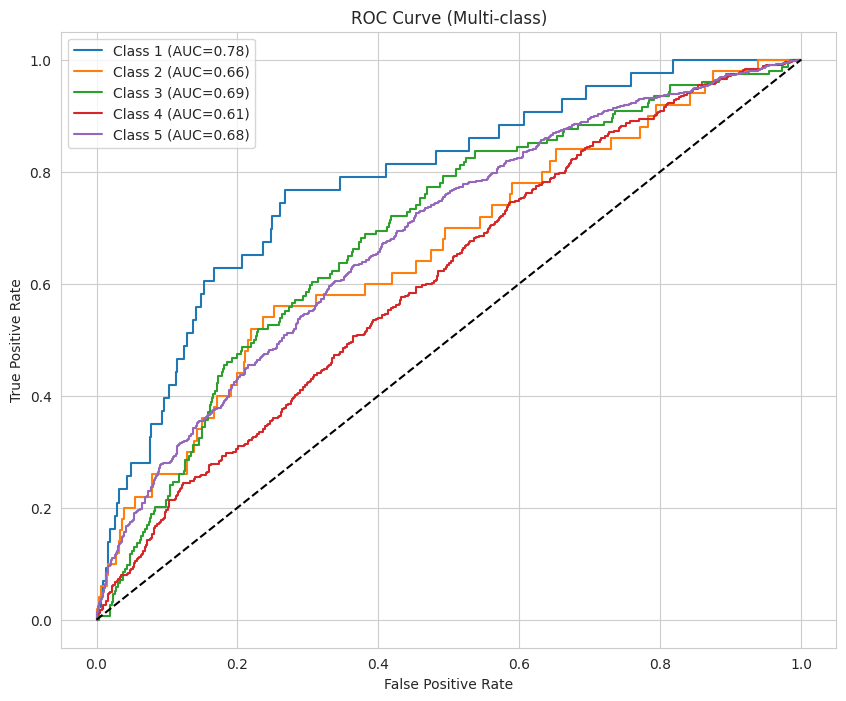

In [32]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_test_clf, best_clf_model.predict(X_test_clf))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_clf_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

plt.close()

# --- ROC Curve ---
mnb_model = MultinomialNB()
mnb_model.fit(X_train_clf, y_train_clf)
y_score = mnb_model.predict_proba(X_test_clf)
y_test_dummies = pd.get_dummies(y_test_clf).values

plt.figure(figsize=(10,8))
for i in range(y_test_dummies.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multi-class)')
plt.legend()
plt.show()
plt.close()


--- REGRESSION ---
Linear Regression: R2=-1.099, RMSE=1.332, Time=0.43s
Decision Tree Regressor: R2=-0.390, RMSE=1.084, Time=5.00s
Random Forest Regressor: R2=0.119, RMSE=0.863, Time=9.49s
Gradient Boosting Regressor: R2=0.161, RMSE=0.842, Time=8.88s
XGBRegressor: R2=0.184, RMSE=0.830, Time=4.62s

REGRESSION RESULTS:
                          Model       MSE      RMSE        R2
0            Linear Regression  1.773299  1.331653 -1.099089
1      Decision Tree Regressor  1.174549  1.083766 -0.390337
2      Random Forest Regressor  0.744244  0.862696  0.119024
3  Gradient Boosting Regressor  0.708521  0.841737  0.161310
4                 XGBRegressor  0.689410  0.830307  0.183932


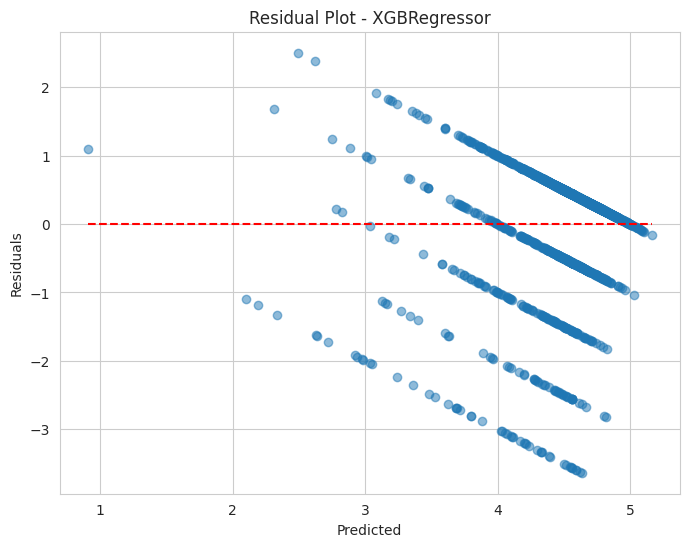

In [33]:
# --- REGRESSION MODELS ---
regressors = {
    "Linear Regression": LinearRegression(n_jobs=-1),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1),
    "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=50, max_depth=5, random_state=42),
    "XGBRegressor": XGBRegressor(n_estimators=50, max_depth=5, random_state=42, n_jobs=-1)
}

results_reg = []
best_r2 = -float('inf')

print("\n--- REGRESSION ---")
for name, model in regressors.items():
    start = time.time()
    model.fit(X_train_reg, y_train_reg)
    y_pred = model.predict(X_test_reg)
    mse = mean_squared_error(y_test_reg, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_reg, y_pred)
    results_reg.append([name, mse, rmse, r2])
    print(f"{name}: R2={r2:.3f}, RMSE={rmse:.3f}, Time={time.time()-start:.2f}s")
    if r2 > best_r2:
        best_r2 = r2
        best_reg_model = model
        best_reg_name = name

results_df_reg = pd.DataFrame(results_reg, columns=["Model", "MSE", "RMSE", "R2"])
print("\nREGRESSION RESULTS:\n", results_df_reg)

# --- Residual Plot ---
y_pred_best = best_reg_model.predict(X_test_reg)
residuals = y_test_reg - y_pred_best
plt.figure(figsize=(8,6))
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.hlines(0, y_pred_best.min(), y_pred_best.max(), colors='r', linestyles='--')
plt.title(f'Residual Plot - {best_reg_name}')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()
plt.close()

